# **实验作业-2：Multiple Linear Regression**
刘蔚璁 10225501443

## **背景描述**
汽车发动机在测功机上产生的**制动马力**被认为是**发动机转速**(每分钟转数，rpm)、**燃料的道路辛烷值**和**发动机压缩值**的函数，我们在实验室里进行实验，研究它们的函数关系。

## **数据描述**

| 变量名 | 变量含义 | 变量类型 | 变量取值范围 |
|:-----:|:-----:|:-----:|:-----:|
| rpm | 发动机转速 | 连续变量 | $R^+$ |
| Road_Octane_Number | 道路辛烷值 | 连续变量 | $R^+$ |
| Compression | 压缩值 | 连续变量 | $R^+$ |
| Brake_Horsepower | 制动马力 | 连续变量 | $R^+$ |

## **任务**
注：这里使用 $\alpha=0.05$ 的显著性水平。

1. 请用多元线性回归模型，描述制动马力和发动机转速、道路辛烷值以及压缩值之间的函数关系。
2. 分别将数据中心化、标准化之后，比较参数估计的异同，并进行评述（提示：可以结合理论课的课件）。
3. 从模型显著性、参数显著性以及残差分析三个角度，分析多元线性回归模型是否合理。
4. 若取发动机转速为3000转/min，道路辛烷值为90，发动机压缩值为100时，分别给出制动马力值的置信区间和预测区间。

## **解决方案**

### **实验前的准备**

本次实验我们载入一些 Python 的安装包，如下：

In [101]:
import os # 修改工作目录

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from jupyterquiz import display_quiz

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f
from scipy.stats import t
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

设置数据目录，如下：

In [2]:
os.chdir(r"C:\Users\86182\Desktop\Statistic\project2") 

### **数据预处理**

导入数据集：

In [3]:
Data = pd.read_csv("Project_3.csv")
print(Data.head())

    rpm  Road Octane Number  Compression  Brake Horsepower
0  2000                  90          100               225
1  1800                  94           95               212
2  2400                  88          110               229
3  1900                  91           96               222
4  1600                  86          100               219


参数设置：

In [4]:
alpha = 0.05

n = Data.shape[0]
p = Data.shape[1] - 1
print("The number of instances is ", n)
print("The number of features is ", p)

The number of instances is  12
The number of features is  3


在本题中，制动马力为响应变量，其他变量作为特征，为简化后续操作，我们将该数据集分为特征和标签两部分：

In [10]:
feature = Data.iloc[:, :-1]
label = Data.iloc[:, -1]

print("特征：")
print(feature.head())
print("标签：")
print(label.head())

特征：
    rpm  Road Octane Number  Compression
0  2000                  90          100
1  1800                  94           95
2  2400                  88          110
3  1900                  91           96
4  1600                  86          100
标签：
0    225
1    212
2    229
3    222
4    219
Name: Brake Horsepower, dtype: int64


### **Q1.请用多元线性回归模型，描述制动马力和发动机转速、道路辛烷值以及压缩值之间的函数关系。**

多元线性回归模型形如
$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_{i}, i=1,2,\cdots,n
$$
其中，$\beta_0,\beta_1,\beta_2$ 分别是未知参数，而 $\epsilon_{i}$ 是误差项，且满足 $E(\epsilon_{i}) = 0$ 和 $Var(\epsilon_{i}) = \sigma^2$。$n$ 表示样本量。

我们可以用矩阵的形式来写这个模型，即
$$
\mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
$$
其中，
- 响应变量构成的向量为
$$
\mathbf{y} = \begin{pmatrix}y_1\\y_2\\\vdots\\ y_n\end{pmatrix},
$$
- 自变量/特征构成的矩阵
$$
\mathbf{X} = \begin{pmatrix}
1 & x_{11} & x_{12} \\
1 & x_{21} & x_{22} \\
\vdots & \vdots & \vdots \\
1 & x_{n1} & x_{n2} \\
\end{pmatrix},
$$
- 待估参数向量为
$$
\mathbf{\beta} = \begin{pmatrix}
\beta_0 \\ \beta_1 \\ \beta_2
\end{pmatrix},
$$
- 误差向量为
$$
\mathbf{\epsilon} = \begin{pmatrix}\epsilon_1\\\epsilon_2\\\vdots\\ \epsilon_n\end{pmatrix}.
$$

#### **方法一：最小二乘法**

由最小二乘法得到的参数向量的估计为：
$$
\hat{\mathbf{\beta}} = (\mathbf{X}'\mathbf{X})^{-1} \mathbf{X}'\mathbf{y}.
$$

构造设计矩阵 $X$ 并把待计算向量都转化为 *numpy* 数组：

In [13]:
X = sm.add_constant(feature).values
y = label.values

np.set_printoptions(suppress=True, precision=4)
print(X[:5])
print(y[:5])

[[   1. 2000.   90.  100.]
 [   1. 1800.   94.   95.]
 [   1. 2400.   88.  110.]
 [   1. 1900.   91.   96.]
 [   1. 1600.   86.  100.]]
[225 212 229 222 219]


进行矩阵计算(将其封装为函数方便之后调用)：

In [21]:
def MatrixCalculus(X,y):
    return np.linalg.inv(X.T @ X) @ X.T @ y
beta_hat_1 = MatrixCalculus(X,y)
print("The estimates of the parameters are \n", 
      np.around(beta_hat_1,4))

The estimates of the parameters are 
 [-266.0312    0.0107    3.1348    1.8674]


#### **方法二：调用 *statmodels* 库**

*statsmodels* 库中的 *ols* 方法是用于执行普通最小二乘法线性回归的函数
- 基本用法

    model = ols(formula, data)

    - formula是一个字符串，定义回归方程的形式。例如，"Y ~ X1 + X2" 表示目标变量 Y 是自变量 X1 和 X2 的线性组合。
    - data是一个 pandas.DataFrame 数据框，包含模型中所有变量。ols 方法会根据 formula 指定的变量名称从数据框中提取相应数据。

先前查看数据集信息得知，共有三个自变量，其列名分别为：rpm, Road Octane Number, Compression，目标变量列名为：Brake Horsepower，可据此拟合模型：

In [19]:
# 重命名列，防止列名出现空格
Data = Data.rename(columns={
    'Brake Horsepower': 'Brake_Horsepower',
    'Road Octane Number': 'Road_Octane_Number'
})

model1 = ols("Brake_Horsepower ~ rpm + Road_Octane_Number + Compression",Data).fit()
beta_hat_2 = model1.params
#print("The estimates of the parameters are \n", 
#      round(model.param(),4))
print("The estimates of the parameters are \n", 
      round(beta_hat_2,4))

The estimates of the parameters are 
 Intercept            -266.0312
rpm                     0.0107
Road_Octane_Number      3.1348
Compression             1.8674
dtype: float64


#### **方法三：调用 *scikit-learn* 库**

In [20]:
model2 = linear_model.LinearRegression()

model2.fit(feature.values, y)
beta_hat_3 = np.append(np.array(model2.intercept_),model2.coef_)

print("The estimates of the parameters are \n", 
      np.around(beta_hat_3,4))

The estimates of the parameters are 
 [-266.0312    0.0107    3.1348    1.8674]


**综上，可写出制动马力和发动机转速、道路辛烷值以及压缩值之间的函数关系**
$$\hat{y}_{\text{Brake Horsepower}} = -266.0312 + 0.0107 x_{\text{rpm}} + 3.1348 x_{\text{Road Octane Number}} + 1.8674 x_{\text{compression}}
$$

### **Q2.分别将数据中心化、标准化之后，比较参数估计的异同，并进行评述（提示：可以结合理论课的课件）。**

线性回归模型为
$$ \begin{aligned}
y &= \bm{x'}\bm{\beta} + \epsilon \\ &= \beta_0+\sum\limits_{j=1}^p\beta_jx_j+\epsilon
\end{aligned}
$$
回归参数 $\beta$ 的估计记为 $\bm{\hat{\beta}}=(\hat{\beta}_{\text{intercep}},\bm{\hat{\beta}}_{\text{slope}})'$

经验回归方程为
$$\hat{y}=\hat{\beta}_{\text{intercept}}+\bm{x'}\bm{\hat{\beta}}_{\text{slope}}$$

#### **中心化**

对每一个变量均减去其均值，即
$$\begin{aligned}
x_{ij}^* &= x_{ij}-\overline{x}_j,\quad \overline{x}_j=n^{-1}\sum\limits_{i=1}^nx_{ij} \\
y_{ij}^* &= y_{i}-\overline{y},\quad \overline{y}=n^{-1}\sum\limits_{i=1}^ny_{i} 
\end{aligned}
$$
令中心化后的数据为
$$\left\{ 
\begin{array}{ll}
\bm{y}^* = (y_1^*,\cdot\cdot\cdot,y_n^*)'\\
\bm{X}_c = (\bm{x}_1^*,\cdot\cdot\cdot,\bm{x}_p^*) \\
\bm{X}^* = (\bm{1}_n,\bm{X}_c)
\end{array} 
\right.$$
其中，$\bm{x}_j^*=(x_{1j}^*,\cdot\cdot\cdot,x_{nj}^*)'$

那么，基于中心化后的数据 $\bm{y}^*$ 和 $\bm{X}^*$，回归参数的估计为
$$\hat{\bm{\beta}}_c = ((\bm{X}^*)'\bm{X}^*)^{-1}(\bm{X}^*)'\bm{y}^*$$


根据上述方法对数据进行中心化，可以看出中心化后的样本均值皆为 0：

In [23]:
X_center = preprocessing.scale(feature.values, with_mean=True, with_std=False)
y_center = preprocessing.scale(y, with_mean=True, with_std=False)

print("The sample means of centered features are ", np.around(np.mean(X_center,axis=0),4))
print("The sample mean of centered response is ", np.around(np.mean(y_center,axis=0),4))

The sample means of centered features are  [-0. -0.  0.]
The sample mean of centered response is  0.0


使用矩阵计算得到参数估计：

In [26]:
X_center_with_intercept = np.hstack((np.ones((X_center.shape[0], 1)), X_center))

beta_hat_center = MatrixCalculus(X_center_with_intercept,y_center)
print(beta_hat_center)

[0.     0.0107 3.1348 1.8674]


调用 *scikit-learn* 库得到参数估计：

In [32]:
model3 = linear_model.LinearRegression()

model3.fit(X_center, y_center)
beta_hat_center2 = np.append(np.array(model3.intercept_),model3.coef_)

print("The estimates of the parameters are \n", 
      np.around(beta_hat_center2,4))

The estimates of the parameters are 
 [0.     0.0107 3.1348 1.8674]


**综上，经中心化后得到的参数估计为**
$$\begin{aligned}
&\hat{\beta}_{\text{c,intercep}} &&= 0 \\
&\bm{\hat{\beta}}_{\text{c,slope}} &&= (0.0107, 3.1348, 1.8674)' \\
&\bm{\hat{\beta}}_{\text{c}}&&=(\hat{\beta}_{\text{c,intercep}},\bm{\hat{\beta}}_{\text{c,slope}}) = (0,0.0107, 3.1348, 1.8674)'
\end{aligned}
$$

#### **标准化**

标准化过程如下：
$$\begin{aligned}
x_{ij}^{**} &= \frac{x_{ij}^*}{\sqrt{L_{jj}}} = \frac{x_{ij}-\overline{x}_j}{\sqrt{L_{jj}}},\quad i=1,2,\cdot\cdot\cdot,n;j=1,2,\cdot\cdot\cdot,p.\\
y_{i}^{**} &= \frac{y_i^*}{\sqrt{L_{yy}}},\quad i=1,2,\cdot\cdot\cdot,n.
\end{aligned}
$$
其中，$L_{jj}$ 是自变量 $x_j$ 的离差平方和，即
$$L_{jj} = \sum\limits_{i=1}^n(x_{ij}-\overline{x}_j)^2$$
而 $L_{yy}$ 是因变量 $y$ 的离差平方和，即
$$L_{yy} = \sum\limits_{i=1}^n(y_{j}-\overline{y})^2$$
令标准化后的数据为
$$\left\{ 
\begin{array}{ll}
\bm{y}^{**} = (\frac{y_1-\overline{y}}{\sqrt{L_{yy}}},\cdot\cdot\cdot,\frac{y_n-\overline{y}}{\sqrt{L_{yy}}})' = \frac{1}{\sqrt{L_{yy}}}\bm{y}^*\\
\bm{X}_s = (\frac{1}{\sqrt{L_{11}}}\bm{x}_1^*,\cdot\cdot\cdot,\frac{1}{\sqrt{L_{pp}}}\bm{x}_p^*)=\bm{X}_c\bm{L} 
\end{array} 
\right.$$
其中，
$$
\bm{L} = \text{diag}\left\{\frac{1}{\sqrt{L_{11}}},\cdot\cdot\cdot,\frac{1}{\sqrt{L_{pp}}}\right\}
$$
因此，最小二乘估计为
$$
\hat{\bm{\beta}}_s = (\hat{\beta}_{\text{s,intercept}},\hat{\bm{\beta}}_{\text{s,slope}})' = (0,\hat{\bm{\beta}}_{\text{s,slope}})'.
$$
回归系数为
$$
\hat{\bm{\beta}}_{\text{s,slope}} = (\bm{X}_{\text{s}}'\bm{X}_{\text{s}})^{-1}\bm{X}_{\text{s}}'\bm{y}^{**}
$$

根据上述方法对数据进行标准化，可以看出标准化后的样本均值皆为 0：

In [28]:
X_standard = preprocessing.scale(feature.values, with_mean=True, with_std=True)
y_standard = preprocessing.scale(y, with_mean=True, with_std=True)

print("The sample means of standardized features are ", np.around(np.mean(X_standard,axis=0),4))
print("The sample mean of standardized response is ", np.around(np.mean(y_standard,axis=0),4))

The sample means of standardized features are  [-0. -0. -0.]
The sample mean of standardized response is  0.0


使用矩阵计算得到参数估计：

In [29]:
beta_hat_standard = MatrixCalculus(X_standard,y_standard)
print(beta_hat_standard)

[0.3757 0.5793 0.5477]


调用 *scikit-learn* 库得到参数估计：

In [31]:
model4 = linear_model.LinearRegression()

model4.fit(X_standard, y_standard)
beta_hat_standard2 = np.append(np.array(model4.intercept_),model4.coef_)

print("The estimates of the parameters are \n", 
      np.around(beta_hat_standard2,4))

The estimates of the parameters are 
 [0.     0.3757 0.5793 0.5477]


**综上，经标准化后得到的参数估计为**
$$\begin{aligned}
&\hat{\beta}_{\text{s,intercep}} &&= 0 \\
&\bm{\hat{\beta}}_{\text{s,slope}} &&= (0.3757 ,0.5793, 0.5477)' \\
&\bm{\hat{\beta}}_{\text{s}}&&=(\hat{\beta}_{\text{s,intercep}},\bm{\hat{\beta}}_{\text{s,slope}}) = (0,0.3757 ,0.5793, 0.5477)'
\end{aligned}
$$

#### **参数估计异同的比较与评述**

$$
\bm{\hat{\beta}}_{\text{c}}=(\hat{\beta}_{\text{c,intercep}},\bm{\hat{\beta}}_{\text{c,slope}}) = (0,0.0107, 3.1348, 1.8674)'\\
\bm{\hat{\beta}}_{\text{s}}=(\hat{\beta}_{\text{s,intercep}},\bm{\hat{\beta}}_{\text{s,slope}}) = (0,0.3757 ,0.5793, 0.5477)'
$$

因为
$$\begin{aligned}
\hat{\bm{\beta}}_{\text{s,slope}} &= (\bm{X}_{\text{s}}'\bm{X}_{\text{s}})^{-1}\bm{X}_{\text{s}}'\bm{y}^{**}\\
&= (\bm{L}\bm{X}_{\text{c}}'\bm{X}_{\text{c}}\bm{L})^{-1}\bm{L}\bm{X}_{\text{c}}'\frac{1}{\sqrt{L_{yy}}}\bm{y}^*\\
&= \frac{1}{\sqrt{L_{yy}}}\bm{L}^{-1}(\bm{X}_{\text{c}}'\bm{X}_{\text{c}})^{-1}\bm{X}_{\text{c}}'\bm{y}^*\\
&= \frac{1}{\sqrt{L_{yy}}}\bm{L}^{-1}\bm{\hat{\beta}}_{\text{c,slope}}
\end{aligned}$$
其中每一个分量为
$$
\hat{\beta}_{\text{s}j}=\frac{\sqrt{L_{jj}}}{\sqrt{L_{yy}}}\hat{\beta}_{\text{c}j}=\frac{\sqrt{L_{jj}}}{\sqrt{L_{yy}}}\hat{\beta}_{j},\quad j=1,2,\cdot\cdot\cdot,p.
$$
且有 $\hat{\beta}_{\text{c,intercep}} = \hat{\beta}_{\text{s,intercep}} = 0$

接下来通过代码验证上述式子，首先计算各变量的离差平方和：

In [34]:
deviation_squared_sum = ((Data - Data.mean()) ** 2).sum()
print("各变量的离差平方和：")
print(deviation_squared_sum)

各变量的离差平方和：
rpm                   3.949167e+06
Road_Octane_Number    1.096667e+02
Compression           2.762500e+02
Brake_Horsepower      3.211000e+03
dtype: float64


把使用上式计算出来的参数与之前直接计算的标准化参数进行比较：

In [39]:
L11 = deviation_squared_sum['rpm']
L22 = deviation_squared_sum['Road_Octane_Number']
L33 = deviation_squared_sum['Compression']
Lyy = deviation_squared_sum['Brake_Horsepower']

beta_hat_s1 = np.sqrt(L11/Lyy)*beta_hat_center[1]
beta_hat_s2 = np.sqrt(L22/Lyy)*beta_hat_center[2]
beta_hat_s3 = np.sqrt(L33/Lyy)*beta_hat_center[3]
print("beta_hat_s1:",round(beta_hat_s1,4))
print("beta_hat_s2:",round(beta_hat_s2,4))
print("beta_hat_s3:",round(beta_hat_s3,4))
print(beta_hat_standard)

beta_hat_s1: 0.3757
beta_hat_s2: 0.5793
beta_hat_s3: 0.5477
[0.3757 0.5793 0.5477]


计算结果相等，既有
$$\begin{aligned}
\hat{\bm{\beta}}_{\text{s,intercep}} &= \hat{\bm{\beta}}_{\text{c,intercep}}\\
\hat{\bm{\beta}}_{\text{s,slope}} &= \frac{1}{\sqrt{L_{yy}}}\bm{L}^{-1}\bm{\hat{\beta}}_{\text{c,slope}}
\end{aligned}$$

- ##### **中心化**
    仅改变了数据的均值，不改变数据的方差和标准差。因此参数估计中的截距（intercept）值会受到影响，通常会变为0（如果模型中包含了常数项），而其他系数的估计值不受影响。
    - 在中心化后，参数估计可能保持在较大的数值范围，因为它们是基于原始数据的尺度。
    - 中心化后的参数估计更容易解释，因为它们仍然反映原始数据的单位。

- ##### **标准化**
    改变了数据的均值和方差，使得数据的分布标准化为均值为0，标准差为1。因此参数估计中会影响所有系数的值，包括截距和斜率，因为数据的尺度发生了变化。
    - 在标准化后，参数估计的数值通常会变小，因为所有特征都被缩放到了相同的尺度。
    - 标准化后的回归系数可以直接用于比较不同特征对标签的相对影响程度。
    - 标准化后的参数估计不再以原始数据的单位表示，因此解释上可能更复杂。

- ##### **评述**
    - **方法选择**
        - 如果模型中包含了多个特征且这些特征的单位和量纲不同，可以使用标准化来消除量纲的影响，尤其是在模型使用了正则化方法时。
        - 如果所有特征的单位和量纲相似，可以选择中心化，以便于简单的模型构建和解释。
    - **模型稳定性**
        - 中心化有助于提高模型的稳定性和准确性，特别是在涉及多重共线性时。
        - 标准化在确保所有特征均衡影响时也能显著提高模型性能。

### **Q3.从模型显著性、参数显著性以及残差分析三个角度，分析多元线性回归模型是否合理。**

#### **模型显著性和参数显著性**

In [46]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:       Brake_Horsepower   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     11.12
Date:                Mon, 14 Oct 2024   Prob (F-statistic):            0.00317
Time:                        21:07:01   Log-Likelihood:                -40.708
No. Observations:                  12   AIC:                             89.42
Df Residuals:                       8   BIC:                             91.36
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -266.0312     92

从上表可知，
- $F$ 检验统计量可以计算为 $11.12$，其 $p$ 值为 $0.00317$，远小于显著性水平 $\alpha = 0.05$。因此，我们认为回归模型是有意义的。
- 对于特征 rpm，Road_Octane_Number 和 Compression，它们的 $t$ 检验统计量分别为 $2.390$，$3.712$ 和 $3.494$，其 $p$ 值均不大于 $0.05$。因此，我们认为这三个特征都是有意义的。

#### **残差分析**

首先根据上方 OLS回归分析表进行解释：
- **Omnibus 和 Prob(Omnibus)**: 用于检验残差的正态性，p 值 0.822 表明残差基本符合正态分布。
- **Durbin-Watson**: 为 1.043，检验残差的自相关性。
- **Jarque-Bera (JB) 和 Prob(JB)**: 用于进一步检验残差的正态性，p 值 0.891 表明残差基本符合正态分布。
- **Skew**: 为 -0.282，表示残差略有左偏。
- **Kurtosis**: 为 2.625，接近于 3，说明残差接近正态分布。

接下来使用上节实验课上的方法进行分析。

残差本质上是数据与所拟合模型之间的差异，即
$$
e_{i} = y_{i} - \hat{y}_{i}
$$ 
在线性回归模型中，
$$
\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{i1} + \hat{\beta}_2 x_{i2}+\cdots+ \hat{\beta}_p x_{ip} , i=1,2,\cdots,n
$$
接下来我们要对残差的独立性、同方差和正态性进行验证。

首先计算残差并画出残差图，对其分布有一个直观的把握：

预测值： [224.2687 225.3282 240.9585 218.8626 207.4442 267.1082 243.7863 237.1246
 235.9067 221.1257 222.1261 233.9601]
残差： [  0.7313 -13.3282 -11.9585   3.1374  11.5558  10.8918   2.2137  -0.1246
  -2.9067   2.8743   0.8739  -3.9601]


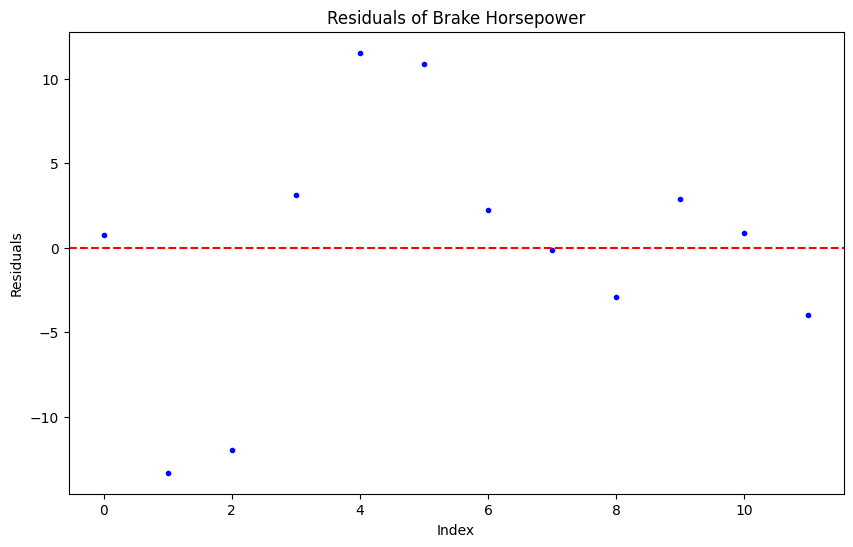

In [49]:
y_pred = X @ beta_hat_1
print("预测值：",y_pred)
residuals = y - y_pred
print("残差：",residuals)

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker=".", color="blue", linestyle="none")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals of Brake Horsepower")
plt.axhline(0, color='red', linestyle='--')  # 添加y=0的参考线
plt.show()


##### **独立性检验**

- ##### **Durbin-Watson检验（简称“DW检验”）**

    这是一种检验序列是否存在一阶自相关性的常用方法。
    对于残差序列 $\{e_i, i = 1,2,\cdots,n,\cdots\}$，考虑残差相关性方程为
    $$
    e_{i} = \rho e_{i-1} + v_{i}, \quad v_i \overset{i.i.d}{\sim} N(0,\sigma_v^2)，
    $$
    其中，$|\rho| < 1$。
    
    DW检验统计量为
    $$
    DW = \frac{\sum_{i=2}^n (e_i - e_{i-1})^2}{\sum_{i=1}^n e_{i}^2}
    $$

    判断规则为
    - 如果 $DW < d_L$, 那么拒绝原假设；
    - 如果 $DW > d_U$, 那么接受原假设；
    - 如果 $d_L \leq DW \leq d_U$, 那么无法判断。

In [53]:
DW = durbin_watson(residuals)
print("DW statistic is", round(DW,4))

DW statistic is 1.0431


查表知 $d_L = 0.51,d_U=2.18,d_L< DW < d_U$，

**所以，**<br>
无法根据 DW 检验判断残差序列是否存在一阶自相关性。

考虑使用别的方法进行独立性检验，其中 Breusch-Godfrey 检验是检验回归模型自相关性的常用方法。
- ##### **Breusch-Godfrey 检验**
    Breusch-Godfrey 检验用于检验回归模型中的自相关性，特别是高阶自相关性。这种检验是线性回归分析中常见的用于验证残差序列的独立性假设的方法，通常也被称为广义 Lagrange 乘数（LM）检验。

    假设
    - 原假设 $\bm{H_0}$：不存在自相关性，即残差之间相互独立
    - 备择假设 $\bm{H_1}$：存在自相关性，即残差之间相关

    检验步骤
    - 估计原始回归模型：首先对数据进行线性回归并得到残差
    - 构建辅助回归模型：
        - 用回归模型的残差作为因变量，回归自变量和滞后残差项
        - 如果你想检验k阶自相关性，则需要包括k个滞后项
    - 计算LM统计量：通常为样本数量乘以辅助回归的决定系数（$LM=nR^2$）
    - 显著性检验：将LM统计量与卡方分布的临界值进行比较
        - 如果p值小于显著性水平（通常为0.05），则拒绝原假设，说明存在自相关性

在 Python 中调用函数分别检验 1 阶、2 阶和 3 阶自相关：

In [95]:
for nlags in range(1, 4):
    bg_test = acorr_breusch_godfrey(model1, nlags=nlags)
    print(f"\n检验阶数: {nlags}")
    print(f"LM统计量: {round(bg_test[0],4)}")
    print(f"p值: {round(bg_test[1],4)}")
    print(f"F统计量: {round(bg_test[2],4)}")
    print(f"F的p值: {round(bg_test[3],4)}")


检验阶数: 1
LM统计量: 3.7565
p值: 0.0526
F统计量: 3.1898
F的p值: 0.1173

检验阶数: 2
LM统计量: 9.226
p值: 0.0099
F统计量: 9.9779
F的p值: 0.0124

检验阶数: 3
LM统计量: 9.2264
p值: 0.0264
F统计量: 5.5441
F的p值: 0.0478


**综上，**<br>
当检验阶数为 $1$ 时 $p$ 值大于显著性水平 $0.05$，所以可以认为残差不存在一阶自相关性。

##### **同方差性检验**

在上节课中，我们学习了 Bartlett 检验和 修正后 levene 检验来检验多个组的方差齐性，而对于线性回归模型，我们检测残差的方差是否恒定（即同方差性），这一假设在模型的有效性和可靠性中至关重要。Breusch-Pagan 检验和 White 检验是常用的两种检验方法。

- ##### **Breusch-Pagan 检验**
    通过回归残差的平方对自变量进行回归，检查是否存在系统性变化。如果回归结果显著，则表示存在异方差性。

    步骤：
    - 拟合线性回归模型：首先，使用最小二乘法拟合线性回归模型，得到残差 $e_i$
    - 计算残差平方：计算残差的平方，即 $e_i^2$
    - 回归残差平方与自变量：对残差平方 $e_i^2$ 进行回归，使用原始模型中的自变量 $$ e_i^2 = \beta_0 + \beta_1\bm{X}_1+ \beta_2\bm{X}_2+ \cdots+\beta_p\bm{X}_p + \bm{\mu}_i $$
        其中 $\bm{X_1},\bm{X_2},...,\bm{X_p}$ 是自变量，$\mu_i$ 是误差项
    - 计算统计量：得到该回归模型的 $R^2$ 值，然后计算 Breusch-Pagan 检验统计量：$$ BP = n\cdot R^2 $$
        其中 $n$ 是样本数量。
    - 显著性检验：$BP$ 统计量遵循卡方分布，查找相应的 $p$ 值。如果 $p$ 值小于设定的显著性水平，则拒绝原假设，表明存在异方差性。

使用 Python 进行 Breusch-Pagan 检验：

In [100]:
bp_test = het_breuschpagan(model1.resid, model1.model.exog)

labels = ['LM Statistic', 'p-value', 'F-Statistic', 'F p-value']
results = dict(zip(labels, bp_test))

print("Breusch-Pagan Test Results:")
for label, result in results.items():
    print(f"{label}: {round(result,4)}")

Breusch-Pagan Test Results:
LM Statistic: 3.6956
p-value: 0.2963
F-Statistic: 1.1867
F p-value: 0.3743


因为 $p$ 值远大于显著性水平 $0.05$，所以接受原假设，即认为存在同方差性。

- ##### **White 检验**
    该检验也用于检测异方差性，但它比Breusch-Pagan检验更加灵活和鲁棒。它不需要对异方差性做出特定假设，因此能够检测更复杂的异方差性模式。

    步骤：
    - 拟合线性回归模型：同样地，首先拟合线性回归模型以获得残差。
    - 构建模型：计算残差的平方 $e_i^2$ 并进行回归。White 检验通常会将所有自变量及其交互项纳入回归，以捕捉更多的异方差性结构：$$ e_i^2 = \beta_0 + \beta_1\bm{X}_1+ \beta_2\bm{X}_2+ \cdots+\beta_p\bm{X}_p + \beta_{p+1}\bm{X}_1\bm{X}_2+ \cdots+\bm{\mu}_i $$
    - 计算统计量：同样地，得到该回归模型的 $R^2$ 值，计算 White 检验统计量：$$W=n\cdot R^2$$
    - 显著性检验：$W$ 统计量也遵循卡方分布。通过查找 $p$ 值来判断是否拒绝原假设。如果 $p$ 值小于设定的显著性水平，则表示存在异方差性。

使用 Python 进行 White 检验：

In [104]:
white_test = het_white(model1.resid, model1.model.exog)

# 输出结果
white_results = pd.Series([round(stat, 4) for stat in white_test], index=['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value'])
print(white_results)

Lagrange Multiplier Statistic    11.1015
p-value                           0.2688
f-value                           2.7456
f p-value                         0.2955
dtype: float64


因为 $p$ 值远大于显著性水平 $0.05$，所以接受原假设，即认为存在同方差性。

##### **正态性检验**

- ##### **Quantile-Quantile 图**

首先绘制 QQ 图，通过图像判断数据是否满足正态性。

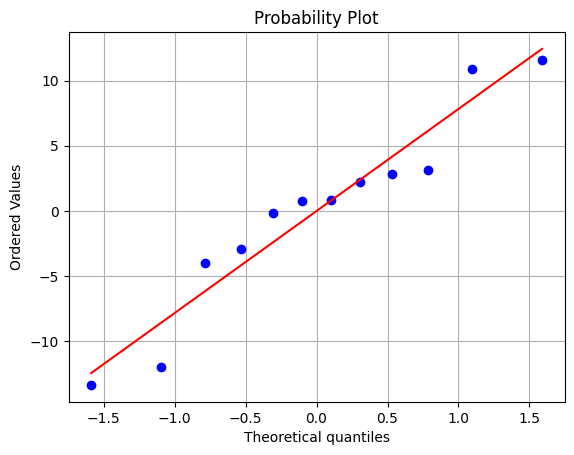

In [84]:
osm, osr = stats.probplot(residuals,dist= "norm",plot= plt)
plt.grid()
plt.show()

根据上图所示，这些点大体落在参考线上，可以认为残差服从正态分布。

- ##### **异常值检测**

    基于残差，我们可以构造标准化残差，即
    $$
    d_{ij} = \frac{e_{ij}}{\sqrt{MS_E}}
    $$
    一般而言，如果残差满足正态分布，那么
    - 约 68\% 落在 $\pm 1$之内；
    - 约 95\% 落在 $\pm 2$之内；
    - 几乎全部落在 $\pm 3$之内。

    如果标准化残差的绝对值大于3，那么所对应的数据可以判断为异常值。

In [85]:
MSE = np.sum(residuals ** 2) / n-p-1
max_abs_residual = np.max(np.abs(residuals))

print("max{d_ij} is",round(max_abs_residual / np.sqrt(MSE),4))

max{d_ij} is 1.9284


由计算结果可知，标准化残差的绝对值的最大值为 $1.9284$，小于 $3$ ，所以认为数据中不包含异常值。

- ##### **Shapiro-Wilk 检验**

    在Shapiro-Wilk 检验中，检验统计量为
    $$
    W = \frac{\left(\sum\limits_{i=1}^n (a_{i}-\bar{a}) (x_{i}-\bar{x})\right)^2}{\sum\limits_{i=1}^n (a_i-\bar{a})^2 \sum\limits_{i=1}^n (x_{(i)} - \bar{x})^2}
    $$
    其中 $a_1,a_2,\cdots,a_n$ 在给定样本量 $n$ 时是一些特定的值。我们所构造的拒绝域是 $\{W\leq W_{\alpha}\}$。

In [87]:
SW_stat,SW_pVal = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic is", round(SW_stat,4))
print("The p value is", round(SW_pVal,4))

Shapiro-Wilk test statistic is 0.9291
The p value is 0.3706


通过计算结果可知 $p$ 值 $=0.2572$ 大于显著性水平 $0.05$

**综上所述，**<br>
接受原假设，即认为残差来自服从正态分布的总体。

##### **综上，认为该线性回归模型的残差存在独立性、同方差性和正态性。**

#### **复相关系数**

除了以上三个角度，还可以从**拟合优度**来**度量回归方程对样本观测值的拟合程度**。

在多元线性回归中，定义样本决定系数为
$$\begin{aligned}
R^2 &= \frac{SS_R}{SS_T}=1-\frac{SS_E}{SS_T}\\
R &= \sqrt{R^2} 
\end{aligned}$$
- $R^2$ 的取值在 $[0,1]$ 区间内
- $R^2$ 越接近 $1$，表明回归拟合的效果越好
- $R^2$ 越接近 $0$，表明回归拟合的效果越差

In [92]:
SSE = residuals.T @ residuals
H = X @ np.linalg.inv(X.T @ X) @ X.T
n1 = np.ones((X.shape[0], 1))
H_1 = n1 @ np.linalg.inv(n1.T @ n1) @ n1.T
SSR = y.T @ (H - H_1) @ y
SST = SSE + SSR
R2 = SSR / SST
print ("R^2 is",round(R2,4))

R^2 is 0.8065


通过计算得到 $R^2$ 为 $0.8065$，可知该回归模型的拟合效果较好。

### **Q4.若取发动机转速为3000转/min，道路辛烷值为90，发动机压缩值为100时，分别给出制动马力值的置信区间和预测区间。**

$y_0$ 的最小方差线性无偏预测为
$$
\hat{y}_0 = \bm{x}_0'\bm{\beta} = \hat{\beta}_0 + x_{01}\hat{\beta}_1+\cdots+x_{0p}\hat{\beta}_p.
$$
预测值 $\hat{y}_0$ 的分布为
$$
\hat{y}_0 \sim N(\bm{x}_0'\bm{\beta},\sigma^2\bm{x}_0'(\bm{X}'\bm{X})^{-1}\bm{x}_0)
$$
$y_0$的分布为
$$
y_0 \sim N(\bm{x}_0'\bm{\beta},\sigma^2)
$$
因为 $\hat{y}_0$ 和 $y_0$ 相互独立，所以 $\hat{y}_0-y_0$ 的分布为
$$
\hat{y}_0-y_0 \sim N(\bm{x}_0'\bm{\beta},\sigma^2(1+\bm{x}_0'(\bm{X}'\bm{X})^{-1}\bm{x}_0))
$$
且有 $\hat{y}_0-y_0$ 与 $\hat{\sigma}^2$ 相互独立。

因为在正态假设 $\bm{y}\sim N(\bm{X\beta},\sigma^2\bm{I}_n)$ 下，有
$$
SS_E/\sigma^2 \sim \chi^2(n-p-1),\text{其中}SS_E=\bm{e}'\bm{e}
$$
于是，
$$
\dfrac{\hat{y}_0-y_0}{\hat{\sigma}\sqrt{1+\bm{x}_0'(\bm{X}'\bm{X})^{-1}\bm{x}_0}}\sim t_{n-p-1}
$$
$y_0$ 的置信水平为 $1-\alpha$ 的预测区间为
$$
\hat{y}_0\pm t_{1-\frac{\alpha}{2}}(n-p-1)\hat{\sigma}\sqrt{1+\bm{x}_0'(\bm{X}'\bm{X})^{-1}\bm{x}_0}
$$
$E(y_0)$ 的置信水平为 $1-\alpha$ 的置信区间为
$$
\hat{y}_0\pm t_{1-\frac{\alpha}{2}}(n-p-1)\hat{\sigma}\sqrt{\bm{x}_0'(\bm{X}'\bm{X})^{-1}\bm{x}_0}
$$
其中，$\hat{\sigma}^2 = (n-p-1)^{-1}\sum_{i=1}^n e_i^2$.

首先整理计算所需的变量与参数：

In [75]:
x_0 = np.array([[1],[3000], [90], [100]])
y_0 = (x_0.T @ beta_hat_1).item()
sigma_hat_2 = np.sum(residuals ** 2) / (n-p-1)
sigma_hat = np.sqrt(sigma_hat_2)
tVal = t.ppf(1-alpha/2, n- p - 1)

#### **置信区间**

In [78]:
temp = tVal * sigma_hat * np.sqrt(x_0.T @ np.linalg.inv(X.T @ X) @ x_0)
confidenceInterval = [round((y_0-temp).item(),4),round((y_0+temp).item(),4)]
print("制动马力值的置信区间为",confidenceInterval)

制动马力值的置信区间为 [226.2457, 243.7181]


#### **预测区间**

In [79]:
temp2 = tVal * sigma_hat * np.sqrt(1 + x_0.T @ np.linalg.inv(X.T @ X) @ x_0)
predInterval = [round((y_0-temp2).item(),4),round((y_0+temp2).item(),4)]
print("制动马力值的预测区间为",predInterval)

制动马力值的预测区间为 [212.8622, 257.1016]


**综上所述，**

发动机转速为3000转/min，道路辛烷值为90，发动机压缩值为100时，
- 制动马力值的置信区间：[226.2457, 243.7181]
- 制动马力值的预测区间：[212.8622, 257.1016]